In [1]:
import tensorflow as tf
import numpy as np
from tensorflow.examples.tutorials.mnist import input_data
mnist = input_data.read_data_sets("/tmp/data/", one_hot=True)

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.
Instructions for updating:
Please write your own downloading logic.
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-images-idx3-ubyte.gz
Instructions for updating:
Please use tf.data to implement this functionality.
Extracting /tmp/data/train-labels-idx1-ubyte.gz
Instructions for updating:
Please use tf.one_hot on tensors.
Extracting /tmp/data/t10k-images-idx3-ubyte.gz
Extracting /tmp/data/t10k-labels-idx1-ubyte.gz
Instructions for updating:
Please use alternatives such as official/mnist/dataset.py from tensorflow/models.


In [2]:
class Residual_net(object):
    def __init__(self,input_size,learning_rate = 0.001):
        self.input_size = input_size
        self.image_width = input_size[0]
        self.image_height = input_size[1]
        self.num_classes = 10
        self.input_x = tf.placeholder("float",name='input',shape = [None, self.image_width, self.image_height,1])
        self.Y = tf.placeholder("float", [None, self.num_classes])
        self.learning_rate = learning_rate
        self.batch_size = 32
    def add_conv(self,x,filters,shape,last_filter):
        if(filters-last_filter != 0):
            zero_padding = tf.zeros([self.batch_size,self.image_width/2, self.image_width/2,filters-last_filter], tf.float32)
            x = tf.concat([x, zero_padding], 3)
        conv1 = tf.layers.conv2d(
          inputs=x,
          filters=filters,
          kernel_size=shape,
          padding="same",
          activation=None)
        conv2 = tf.layers.conv2d(
          inputs=conv1,
          filters=filters,
          kernel_size=shape,
          padding="same",
          activation=None)
        new_x = x + conv1
        return tf.nn.relu(new_x)
    def build(self):
        input_layer = tf.reshape(self.input_x, [-1, self.image_width, self.image_height, 1])
        conv1 = tf.layers.conv2d(
          inputs=input_layer,
          filters=64,
          kernel_size=[7,7],
          padding="same",
          activation=None)
        pool1 = tf.layers.max_pooling2d(inputs=conv1, pool_size=[2, 2], strides=2)
        temp = pool1
        last_filter = 64
        for i in range(3):
            temp = self.add_conv(temp,64,[3,3],last_filter)
            last_filter = 64
        for i in range(4):
            temp = self.add_conv(temp,128,[3,3],last_filter)
            last_filter = 128
        for i in range(6):
            temp = self.add_conv(temp,256,[3,3],last_filter)
            last_filter = 256
        for i in range(3):
            temp = self.add_conv(temp,512,[3,3],last_filter)
            last_filter = 512
        avg_pool1 = tf.layers.average_pooling2d(inputs=temp, pool_size=[2, 2], strides=2)
        flatten = tf.contrib.layers.flatten(
          avg_pool1,
          outputs_collections=None,
          scope=None
        )
        num_classes = 10
        weights = {
            'w1': tf.Variable(tf.random_normal([tf.shape(flatten)[1], 1000])),
            'w2': tf.Variable(tf.random_normal([1000, num_classes]))
        }
        biases = {
            'b1': tf.Variable(tf.random_normal([1000])),
            'b2': tf.Variable(tf.random_normal([num_classes]))
        }
        temp = tf.nn.relu(tf.matmul(flatten, weights['w1']) + biases['b1'])
        logits = tf.matmul(temp, weights['w2']) + biases['b2']
        prediction = tf.nn.softmax(logits)
        """
        loss
        """
        # Define loss and optimizer
        self.loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(
            logits=logits, labels=self.Y))
        self.optimizer = tf.train.AdamOptimizer(learning_rate=self.learning_rate)
        self.train_op = self.optimizer.minimize(self.loss_op)
        
        # Evaluate model (with test logits, for dropout to be disabled)
        self.correct_pred = tf.equal(tf.argmax(prediction, 1), tf.argmax(self.Y, 1))
        self.accuracy = tf.reduce_mean(tf.cast(self.correct_pred, tf.float32))
    def train(self,mnist,training_steps,batch_size = 32):
        # Initialize the variables (i.e. assign their default value)
        init = tf.global_variables_initializer()
        display_step = 100
        # Start training
        results = []
        with tf.Session() as sess:

            # Run the initializer
            sess.run(init)

            for step in range(1,training_steps+1):
                batch_x, batch_y = mnist.train.next_batch(batch_size)
                # Reshape data to get 28 seq of 28 elements
                batch_x = batch_x.reshape((batch_size, self.image_width, self.image_height,1))
                # Run optimization op (backprop)
                sess.run(self.train_op, feed_dict={self.input_x: batch_x, self.Y: batch_y})
                if step % display_step == 0 or step == 1:
                    # Calculate batch loss and accuracy
                    loss, acc = sess.run([self.loss_op, self.accuracy], feed_dict={self.input_x: batch_x,
                                                                        self.Y: batch_y})
                    results.append(acc)
                    print("Step " + str(step) + ", Minibatch Loss= " + \
                          "{:.4f}".format(loss) + ", Training Accuracy= " + \
                          "{:.3f}".format(acc))

            print("Optimization Finished!")
            return results
            # Calculate accuracy for 128 mnist test images
            test_len = 128
            test_data = mnist.test.images[:test_len].reshape((-1, self.image_width, self.image_height))
            test_label = mnist.test.labels[:test_len]
            print("Testing Accuracy:", 
            sess.run(self.accuracy, feed_dict={self.input_x: test_data, self.Y: test_label}))
            

In [3]:
net = Residual_net([28,28])
net.build()

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See @{tf.nn.softmax_cross_entropy_with_logits_v2}.



In [4]:
results = net.train(mnist,2000)

Step 1, Minibatch Loss= 78586.9375, Training Accuracy= 0.156
Step 100, Minibatch Loss= 2.2602, Training Accuracy= 0.219
Step 200, Minibatch Loss= 2.8011, Training Accuracy= 0.188
Step 300, Minibatch Loss= 1.1212, Training Accuracy= 0.656
Step 400, Minibatch Loss= 0.3738, Training Accuracy= 0.906
Step 500, Minibatch Loss= 0.4542, Training Accuracy= 0.844
Step 600, Minibatch Loss= 0.4248, Training Accuracy= 0.844
Step 700, Minibatch Loss= 0.4123, Training Accuracy= 0.875
Step 800, Minibatch Loss= 0.1217, Training Accuracy= 0.938
Step 900, Minibatch Loss= 0.1634, Training Accuracy= 0.969
Step 1000, Minibatch Loss= 0.0304, Training Accuracy= 1.000
Step 1100, Minibatch Loss= 0.2591, Training Accuracy= 0.906
Step 1200, Minibatch Loss= 0.1485, Training Accuracy= 0.938
Step 1300, Minibatch Loss= 0.2590, Training Accuracy= 0.938
Step 1400, Minibatch Loss= 0.1280, Training Accuracy= 0.969
Step 1500, Minibatch Loss= 0.1954, Training Accuracy= 0.969
Step 1600, Minibatch Loss= 0.0404, Training Accu

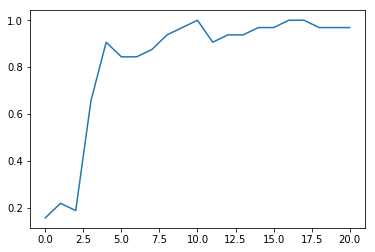

In [6]:
from matplotlib import pyplot as plt
plt.plot(range(len(results)),results)
plt.show()